In [0]:
import cv2
import glob
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import shutil
import tensorflow as tf
import time
import warnings
from google.colab import drive
from keras import backend as K
from keras.engine.topology import Input
from keras.layers.advanced_activations import PReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, ZeroPadding2D
from keras.layers.core import SpatialDropout2D, Permute, Activation, Reshape
from keras.layers.merge import add, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.metrics import binary_crossentropy
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from pprint import pprint
from random import shuffle
from shutil import copy2
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

In [0]:
% matplotlib inline
warnings.filterwarnings("ignore")
IMAGE_HEIGHT = 400 
IMAGE_WIDTH = 400
gpu_options = tf.GPUOptions(allow_growth=True)

In [0]:
# Functions to output custom metrics such as recall,f1 score during training
def model_recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def model_precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def model_f1(y_true, y_pred):
    precision = model_recall(y_true, y_pred)
    recall = model_recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [0]:
# Function to compute mean iou during prediction from model
def compute_iou(y_pred, y_true):
     current = confusion_matrix(y_true, y_pred, labels=[0, 1])
     intersection = np.diag(current)
     ground_truth_set = current.sum(axis=1)
     predicted_set = current.sum(axis=0)
     union = ground_truth_set + predicted_set - intersection
     IoU = intersection / union.astype(np.float32)
     return np.mean(IoU)

In [0]:
def split_data(image_path, masks_path, split_path):
    images = glob.glob( image_path + "*.jpg")
    masks = glob.glob( masks_path + "*.jpg")
    images.sort()
    masks.sort()
    print ("Total Images = {}".format(len(images)))
    print ("Total Labels = {}".format(len(masks)))
    assert len(images) == len(masks)    
    for im, seg in zip(images,masks):
        assert(im.split('/')[-1].split(".")[0] ==  seg.split('/')[-1].split(".")[0])
    
    shuffle(images)

    directory = [ split_path + '/train/images/', 
                  split_path + '/train/mask/',
                  split_path + '/valid/images/', 
                  split_path + '/valid/mask/',
                  split_path + '/test/images/', 
                  split_path + '/test/mask/']
    
    for i in directory:
        if not os.path.exists(i):
            os.makedirs(i)
    
    length = len(images)
    train = int(0.7 * length)
    test = int(0.15 * length)
    valid  = length - train - test
    for i, j in enumerate(images):
        j = j.split('/')[-1].split(".")[0]
        if i <=0.7*length:
            shutil.copy2(image_path +j+".jpg", directory[0])
            shutil.copy2(masks_path +j+".jpg", directory[1])
        elif i<= 0.85*length :
            shutil.copy2(image_path +j+".jpg", directory[2])
            shutil.copy2(masks_path +j+".jpg", directory[3])
        else:
            shutil.copy2(image_path +j+".jpg", directory[4])
            shutil.copy2(masks_path +j+".jpg", directory[5])
    pass

In [0]:
# Functions to be used during Image Augumentation
def random_brightness(image):
    # Convert 2 HSV colorspace from BGR colorspace
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Generate new random brightness
    rand = random.uniform(0.3, 1.0)
    hsv[:, :, 2] = rand*hsv[:, :, 2]
    # Convert back to BGR colorspace
    new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return new_img

# Zoom-in
def zoom(image):
    zoom_pix = random.randint(0, 10)
    zoom_factor = 1 + (2*zoom_pix)/IMAGE_HEIGHT
    image = cv2.resize(image, None, fx=zoom_factor,
                       fy=zoom_factor, interpolation=cv2.INTER_LINEAR)
    top_crop = (image.shape[0] - IMAGE_HEIGHT)//2
    left_crop = (image.shape[1] - IMAGE_WIDTH)//2
    image = image[top_crop: top_crop+IMAGE_HEIGHT,
                  left_crop: left_crop+IMAGE_WIDTH]
    return image

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
img_path = '/content/drive/My Drive/Lane_Detection/binary_lane_bdd/Images/'
label_path = '/content/drive/My Drive/Lane_Detection/binary_lane_bdd/Labels/'
split_path = '/content/drive/My Drive/Lane_Detection/binary_lane_bdd/Split/'

In [0]:
split_data(img_path, label_path, split_path)

In [0]:
split_train_image = split_path + "/train/images/"
split_train_mask = split_path + "/train/mask/"
split_test_image = split_path + "/test/images/"
split_test_mask = split_path + "/test/mask/"
split_val_image = split_path + "/valid/images/"
split_val_mask = split_path + "/valid/mask/"

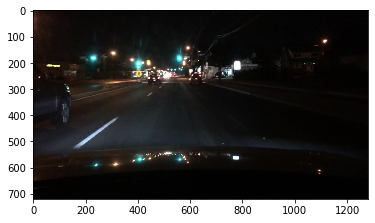

In [0]:
img = cv2.imread(split_train_image + os.listdir(split_train_image)[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

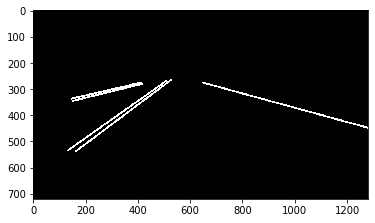

In [0]:
mask = cv2.imread(split_train_mask + os.listdir(split_train_mask)[0]) 
plt.imshow(mask)

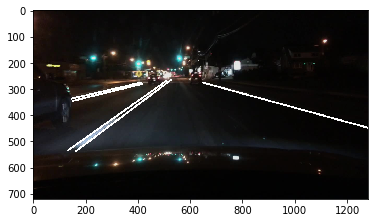

In [0]:
output = cv2.addWeighted(img, 0.9, mask, 1, 1)
plt.imshow(output)

In [0]:
def generator(
    image_path, mask_path, batch_size, input_height, input_width, labels, is_train
):

    assert image_path[-1] == "/"
    assert mask_path[-1] == "/"

    images = glob.glob(image_path + "*.jpg")
    segmentations = glob.glob(mask_path + "*.jpg")
    images.sort()
    segmentations.sort()

    assert len(images) == len(segmentations)

    for im, seg in zip(images, segmentations):
        assert im.split("/")[-1].split(".")[0] == seg.split("/")[-1].split(".")[0]

    zipped = itertools.cycle(zip(images, segmentations))

    while True:
        X = []
        Y = []
        for _ in range(batch_size):
            im, seg = next(zipped)
            # reading image
            img = cv2.imread(im)[:, :, ::-1]
            img1 = cv2.imread(seg, 0)
            should_augment = random.randint(0, 1)
            if is_train == 1:
                if should_augment:
                    should_chng_brightness = random.randint(0, 1)
                    should_flip = random.randint(0, 1)
                    should_zoom = random.randint(0, 1)
                    if should_flip == 1:
                        img = cv2.flip(img, 1)
                        img1 = cv2.flip(img1, 1)
                    elif should_zoom == 1:
                        img = zoom(img)
                        img1 = zoom(img1)
                    elif should_chng_brightness == 1:
                        img = random_brightness(img)
            img = cv2.resize(
                img, (input_width, input_height), interpolation=cv2.INTER_NEAREST
            )
            # Scaling the input image
            img = img.astype(np.float32)
            img = img / 255.0

            X.append(img)

            img1 = cv2.resize(
                img1, (input_width, input_height), interpolation=cv2.INTER_NEAREST
            )
            seg_labels = np.zeros((input_height, input_width, len(labels)))

            # Transforming into binary
            for c, l in enumerate(labels):
                seg_labels[:, :, c] = ((img1 == l)) * 1

            seg_labels = seg_labels.astype(np.float32)
            Y.append(seg_labels)

        yield np.array(X), np.array(Y)

In [0]:
def downsample_bottleneck(o, output_size, asymmetric=0, dilated=0, downsample=0):

    second_branch = o
    input_n_channels = o.get_shape().as_list()[3]
    padding = output_size - input_n_channels

    # reducing the channels (1x1)
    if downsample:
        stride = 2
    else:
        stride = 1

    o = Conv2D(
        output_size // 4, (stride, stride), strides=(stride, stride), use_bias=False
    )(o)
    o = BatchNormalization(momentum=0.1)(o)
    o = PReLU(shared_axes=[1, 2])(o)

    # Perfroming convolution (COnv)
    if asymmetric:
        o = Conv2D(output_size // 4, (1, asymmetric), padding="same", use_bias=False)(o)
        o = Conv2D(output_size // 4, (asymmetric, 1), padding="same")(o)
    else:
        if dilated:
            o = Conv2D(
                output_size // 4,
                (3, 3),
                dilation_rate=(dilated, dilated),
                padding="same",
            )(o)
        else:
            o = Conv2D(output_size // 4, (3, 3), padding="same")(o)

    o = BatchNormalization(momentum=0.1)(o)
    o = PReLU(shared_axes=[1, 2])(o)

    # Producing back the channels (1x1)
    o = Conv2D(output_size, (1, 1), use_bias=False)(o)
    o = BatchNormalization(momentum=0.1)(o)

    # Performing regularization (Regularizer)
    o = SpatialDropout2D(0.1)(o)

    # Second branch

    # performing max pooling only if downsample
    if downsample:
        second_branch = MaxPooling2D()(second_branch)

        # performing padding -- only required if downsampling
        second_branch = Permute((1, 3, 2))(second_branch)
        second_branch = ZeroPadding2D(padding=((0, 0), (0, padding)))(second_branch)
        second_branch = Permute((1, 3, 2))(second_branch)

    o = add([o, second_branch])
    o = PReLU(shared_axes=[1, 2])(o)

    return o

In [0]:
def upsample_bottleneck(o, output_size, upsample=0):

    other_branch = o

    # reducing the number of channel by 1x1 convolution
    o = Conv2D(output_size // 4, (1, 1), use_bias=False)(o)
    o = BatchNormalization(momentum=0.1)(o)
    o = Activation("relu")(o)

    # Perfroming upsmapling if asked for otherwise performing normal convolution operation
    if upsample:
        o = Conv2DTranspose(
            output_size // 4, kernel_size=(3, 3), strides=(2, 2), padding="same"
        )(o)
    else:
        o = Conv2D(output_size // 4, (3, 3), padding="same", use_bias=True)(o)

    o = BatchNormalization(momentum=0.1)(o)
    o = Activation("relu")(o)

    # Producing back the channels
    o = Conv2D(output_size, (1, 1), padding="same", use_bias=False)(o)

    # Upsampling the other branch as well if upsampling is required
    if upsample:
        other_branch = Conv2D(output_size, (1, 1), padding="same", use_bias=False)(
            other_branch
        )
        other_branch = BatchNormalization(momentum=0.1)(other_branch)
        other_branch = UpSampling2D(size=(2, 2))(other_branch)

    # Adding the two branches
    o = BatchNormalization(momentum=0.1)(o)
    o = add([o, other_branch])
    o = Activation("relu")(o)

    return o

In [0]:
def ENet(n_classes, input_height, input_width, channels):

    # defining teh Input size
    img_input = Input(shape=(input_height, input_width, channels))

    ## Section Initial
    conv = Conv2D(13, (3, 3), padding="same", strides=(2, 2))(img_input)
    max_pool = MaxPooling2D()(img_input)
    merged = concatenate([conv, max_pool], axis=3)
    o = BatchNormalization(momentum=0.1)(merged)
    o = PReLU(shared_axes=[1, 2])(o)
    ### Section Initial End

    ##Section 2 and 3
    o = downsample_bottleneck(o, 64, downsample=True)  # 1.1

    for _ in range(4):  # 1.2-1.5
        o = downsample_bottleneck(o, 64)

    o = downsample_bottleneck(o, 128, downsample=True)  # 2.0

    for _ in range(2):
        o = downsample_bottleneck(o, 128)  # 2.1
        o = downsample_bottleneck(o, 128, dilated=2)  # 2.2
        o = downsample_bottleneck(o, 128, asymmetric=5)  # 2.3
        o = downsample_bottleneck(o, 128, dilated=4)  # 2.4
        o = downsample_bottleneck(o, 128)  # 2.5
        o = downsample_bottleneck(o, 128, dilated=8)  # 2.6
        o = downsample_bottleneck(o, 128, asymmetric=5)  # 2.7
        o = downsample_bottleneck(o, 128, dilated=16)  # 2.8

    ## Section 2 and 3 end

    ## Section 4
    o = upsample_bottleneck(o, 64, upsample=True)  # 4.0
    o = upsample_bottleneck(o, 64)  # 4.1
    o = upsample_bottleneck(o, 64)  # 4.2
    # Section 4 ends

    # Section 5
    o = upsample_bottleneck(o, 16, upsample=True)  # bottleneck 5.0
    o = upsample_bottleneck(o, 16)  # bottleneck 5.1
    # section 5 ends

    o = Conv2DTranspose(
        filters=n_classes, kernel_size=(2, 2), strides=(2, 2), padding="same"
    )(o)

    o = Activation("softmax")(o)
    model = Model(img_input, o)

    return model


In [0]:
model = ENet(2, 704, 1280, 3)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
train_gen = generator(split_train_image, split_train_mask, 1 , 704, 1280, [0, 255], 1)

In [0]:
valid_gen = generator(split_val_image, split_val_mask, 1 , 704, 1280, [0, 255], 0)

In [0]:
test_gen = generator(split_test_image, split_test_mask, 1 , 704, 1280, [0, 255], 0)

In [0]:
b,c = next(train_gen)

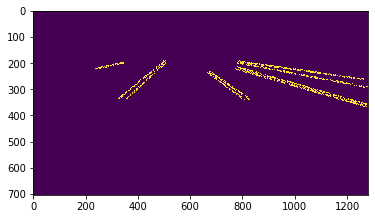

In [0]:
plt.imshow(c[0].argmax(axis=2) * 255)

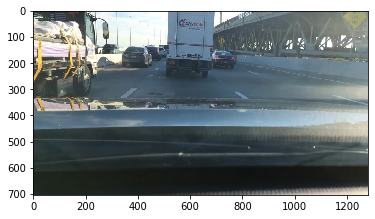

In [0]:
plt.imshow(b[0])

In [0]:
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(lr=0.001),
    metrics=["accuracy", mean_iou, model_precision, model_recall, model_f1],
)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [27]:
lane_model_history = model.fit_generator(
    train_gen,
    validation_data=valid_gen,
    validation_steps=len(os.listdir(split_train_image)),
    steps_per_epoch=len(os.listdir(split_train_image)),
    epochs=10,
)



Epoch 1/10
351/351 [==============================] - 152s 434ms/step - loss: 0.1513 - acc: 0.9548 - mean_iou: 0.7012 - model_precision: 0.9479 - model_recall: 0.9612 - model_f1: 0.9612 - val_loss: 0.0827 - val_acc: 0.9803 - val_mean_iou: 0.8815 - val_model_precision: 0.9746 - val_model_recall: 0.9857 - val_model_f1: 0.9857
Epoch 2/10
351/351 [==============================] - 123s 350ms/step - loss: 0.0774 - acc: 0.9794 - mean_iou: 0.9096 - model_precision: 0.9724 - model_recall: 0.9861 - model_f1: 0.9861 - val_loss: 0.0849 - val_acc: 0.9803 - val_mean_iou: 0.9211 - val_model_precision: 0.9747 - val_model_recall: 0.9858 - val_model_f1: 0.9858
Epoch 3/10
351/351 [==============================] - 123s 351ms/step - loss: 0.0709 - acc: 0.9801 - mean_iou: 0.9281 - model_precision: 0.9734 - model_recall: 0.9865 - model_f1: 0.9865 - val_loss: 0.0822 - val_acc: 0.9799 - val_mean_iou: 0.9316 - val_model_precision: 0.9741 - val_model_recall: 0.9854 - val_model_f1: 0.9854
Epoch 4/10
351/351 [

In [29]:
pprint(lane_model_history.history)

{'acc': [0.954818342825626,
         0.9793743903820331,
         0.9800728056845163,
         0.9791993507292875,
         0.9798826295086461,
         0.9782545958828722,
         0.9791484619477535,
         0.9795682939708742,
         0.9795062934231554,
         0.9792728580300964],
 'loss': [0.1513432985081462,
          0.07741680037113506,
          0.07090220011324964,
          0.07236364883161084,
          0.06857778734800822,
          0.07431271527111105,
          0.06785564276885953,
          0.06665626317368784,
          0.0651743617519057,
          0.06578601058837864],
 'mean_iou': [0.701235225397637,
              0.9096371964511708,
              0.928134163560351,
              0.9340214924594955,
              0.9378899101518158,
              0.9405494687224385,
              0.9418128810377202,
              0.9429996514592076,
              0.943794554624802,
              0.9447071036042651],
 'model_f1': [0.9611544739826452,
              0.9861144538958

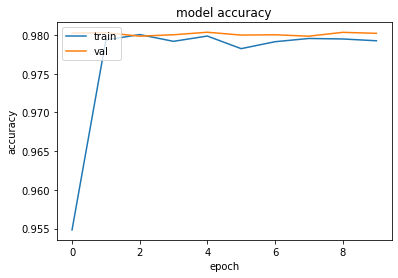

In [31]:
plt.plot(lane_model_history.history['acc'])
plt.plot(lane_model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

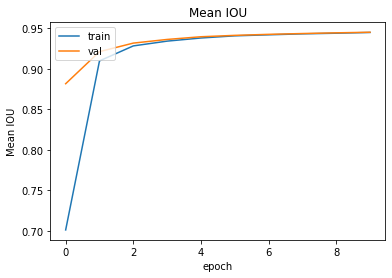

In [32]:
plt.plot(lane_model_history.history['mean_iou'])
plt.plot(lane_model_history.history['val_mean_iou'])
plt.title('Mean IOU')
plt.ylabel('Mean IOU')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
def read_img(location, not_mask):
    if not_mask == 1:
        img = cv2.imread(location)[:, :, ::-1]
    else:
        img = cv2.imread(location)[:, :, 0]
        img = cv2.imread(location, 0)
    img = cv2.resize(img, (1280, 704), interpolation=cv2.INTER_NEAREST)
    img = img.astype(np.float32)
    img = img / 255.0
    if not_mask == 1:
        img = img[np.newaxis]
    return img

In [0]:
def plot_predictions(model, test_image_location, test_mask_location):

    y_true = read_img(location=mask_loc, not_mask=0)
    y_pred = model.predict(read_img(location=img_loc, not_mask=1))[0].argmax(axis=2)
    fig = plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(read_img(img_loc, not_mask=1)[0])
    plt.axis("off")
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(y_true)
    plt.axis("off")
    plt.title("True Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(y_pred)
    plt.axis("off")
    plt.title("Prediction")
    plt.show()
    target = y_true.ravel()
    target = target.astype(int)
    predicted = y_pred.ravel()
    recall = recall_score(target, predicted)
    precision = precision_score(target, predicted)
    f1 = f1_score(target, predicted)
    iou_value = compute_iou(target, predicted)
    print("IOU Score = {}".format(iou_value))
    print("F1 Score = {}".format(f1))
    print("Recall = {}".format(recall))
    print("Precision = {}".format(precision))
    pass

In [0]:
mask_loc = split_test_mask + os.listdir(split_test_mask)[2]
img_loc = split_test_image + os.listdir(split_test_image)[2]

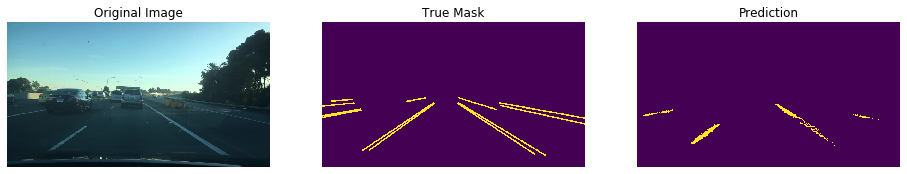

IOU Score = 0.5869696894111762
F1 Score = 0.322670489453205
Recall = 0.24502363772082608
Precision = 0.4723587960187073


In [76]:
plot_predictions(model, img_loc, mask_loc)

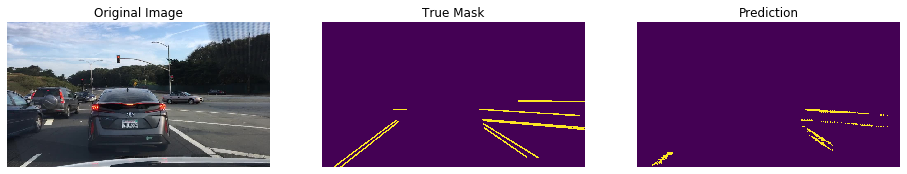

IOU Score = 0.5902000426479952
F1 Score = 0.331018999708976
Recall = 0.2534377387318564
Precision = 0.477052127022169


In [87]:
mask_loc = split_test_mask + os.listdir(split_test_mask)[4]
img_loc = split_test_image + os.listdir(split_test_image)[4]
plot_predictions(model, img_loc, mask_loc)

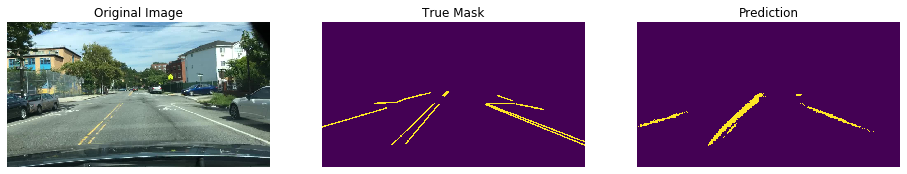

IOU Score = 0.5816616912316779
F1 Score = 0.31037475940672526
Recall = 0.3601015850775024
Precision = 0.2727152142193925


In [86]:
mask_loc = split_test_mask + os.listdir(split_test_mask)[6]
img_loc = split_test_image + os.listdir(split_test_image)[6]
plot_predictions(model, img_loc, mask_loc)

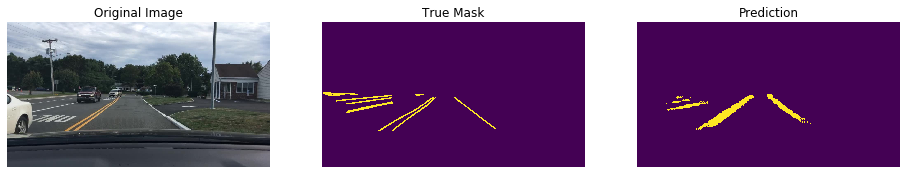

IOU Score = 0.603306813155854
F1 Score = 0.36705022547037786
Recall = 0.49957671957671956
Precision = 0.2900946294703208


In [89]:
mask_loc = split_test_mask + os.listdir(split_test_mask)[31]
img_loc = split_test_image + os.listdir(split_test_image)[31]
plot_predictions(model, img_loc, mask_loc)

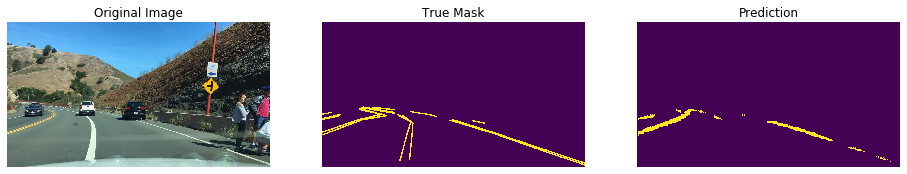

IOU Score = 0.6394862658682265
F1 Score = 0.45718878870482976
Recall = 0.42827211418843714
Precision = 0.49029308147815004


In [90]:
mask_loc = split_test_mask + os.listdir(split_test_mask)[39]
img_loc = split_test_image + os.listdir(split_test_image)[39]
plot_predictions(model, img_loc, mask_loc)

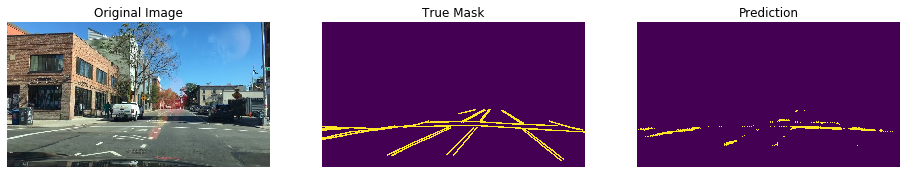

IOU Score = 0.5741326656135202
F1 Score = 0.2992513066817347
Recall = 0.21389337641357029
Precision = 0.4979783732957217


In [91]:
mask_loc = split_test_mask + os.listdir(split_test_mask)[54]
img_loc = split_test_image + os.listdir(split_test_image)[54]
plot_predictions(model, img_loc, mask_loc)

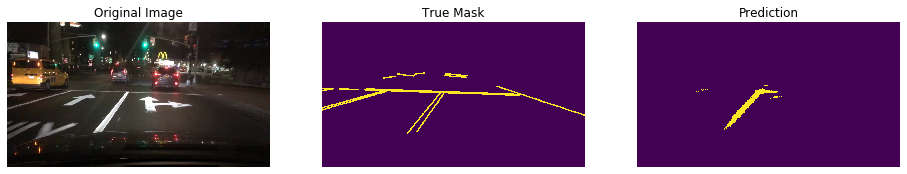

IOU Score = 0.5418974860049693
F1 Score = 0.19294062463354572
Recall = 0.13941139919787607
Precision = 0.3131979695431472


In [92]:
mask_loc = split_test_mask + os.listdir(split_test_mask)[51]
img_loc = split_test_image + os.listdir(split_test_image)[51]
plot_predictions(model, img_loc, mask_loc)